In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
import pyspark
from pathlib import Path
import csv
import datetime
import statistics

Matplotlib is building the font cache; this may take a moment.


In [37]:
# Preprocessing

In [38]:
# returns list of timestamps and list of glucose_values for each user. Could pair them and return a combined list
def proc_glucose(path):
    user_value = str(path)[-2:] if str(path)[-2:].isdigit() else str(path)[-1]
    # full_path = f"{str(path).replace("\\", "/")}/Glucose/CGM_User{user_value}.csv"
    full_path = f"{Path(path).as_posix()}/Glucose/CGM_User{user_value}.csv"
    df = pd.read_csv(full_path)
    timestamps = df["Timestamp (YYYY-MM-DDThh:mm:ss)"].tolist()
    glucose_values = df["Glucose Value (mg/dL)"].tolist()
    return timestamps, glucose_values, df, user_value

allowed_sensor_ids = [18, 19, 21]

sensor_map = {
    1:  "ACCELEROMETER",
    2:  "MAGNETIC_FIELD",
    4:  "GYROSCOPE",
    9:  "GRAVITY",
    10: "LINEAR_ACCELERATION",
    11: "ROTATION_VECTOR",
    18: "STEP_DETECTOR",
    19: "STEP_COUNTER",
    21: "HEART_RATE",
    99: "EARTH_ACC"
}

sensor_data = {
    "ACCELEROMETER": [],
    "MAGNETIC_FIELD": [],
    "GYROSCOPE": [],
    "GRAVITY": [],
    "LINEAR_ACCELERATION": [],
    "ROTATION_VECTOR": [],
    "STEP_DETECTOR": [],
    "STEP_COUNTER": [],
    "HEART_RATE": [],
    "EARTH_ACC": []
}

def proc_sensors(path, device_label):
    chunk_list = []
    full_path = Path(path).as_posix()  # Clean path
    for chunk in pd.read_csv(full_path, header=None, names=["sensor_id", "timestamp", "val1", "val2", "val3"], chunksize=50_000, low_memory=False):
        filtered_chunk = chunk.loc[chunk["sensor_id"].isin(allowed_sensor_ids)].copy()
        filtered_chunk["timestamp"] = pd.to_datetime(filtered_chunk["timestamp"], unit="ms", utc=True)
        filtered_chunk["device"] = device_label
        chunk_list.append(filtered_chunk)
    return pd.concat(chunk_list, ignore_index=True)


In [40]:
patient_dfs = {}

In [42]:
patient_folder = Path("Datasets/glucdict-1/Glucdict Dataset")
for user_dir in patient_folder.iterdir():
    if not user_dir.is_dir():
        continue
    
    all_dfs = []

    timestamps, glucose_values, gluc_df, user_value = proc_glucose(user_dir)

    #all_dfs.append(gluc_df)
    
    phone_path = Path(f"{user_dir}/Phone/Sensors")
    watch_path = Path(f"{user_dir}/Watch")
    
    if phone_path.is_dir():
        for i in phone_path.iterdir():
            if i.is_file() and i.suffix.lower() == '.csv':
                df = proc_sensors(i, "phone")
                all_dfs.append(df)
    if watch_path.is_dir():
        for j in watch_path.iterdir():
            if j.is_file() and j.suffix.lower() == '.csv':
                watch_sensors = proc_sensors(j, "watch")
                all_dfs.append(watch_sensors)

    patient_df = pd.concat(all_dfs, ignore_index=True)
    patient_df["sensor_name"] = patient_df["sensor_id"].map(sensor_map)
    patient_dfs[f"User {user_value}"] = {
        "Sensor Data" : patient_df,
        "Glucose Data" : gluc_df
    }

/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/318136324.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(chunk_list, ignore_index=True)


In [44]:
print(patient_df.columns)
print(patient_dfs.keys())
print(patient_dfs['User 10']['Glucose Data'])
#print(patient_dfs['User 1']['Sensor Data'])
#print(patient_dfs['User 1']['Glucose Data'])

Index(['sensor_id', 'timestamp', 'val1', 'val2', 'val3', 'device',
       'sensor_name'],
      dtype='object')
dict_keys(['User 5', 'User 4', 'User 3', 'User 14', 'User 13', 'User 12', 'User 15', 'User 8', 'User 6', 'User 1', 'User 7', 'User 9', 'User 10'])
      Index Timestamp (YYYY-MM-DDThh:mm:ss) Glucose Value (mg/dL)  \
0         1             2021-12-21T14:01:57                   129   
1         2             2021-12-21T14:06:57                   138   
2         3             2021-12-21T14:11:57                   129   
3         4             2021-12-21T14:16:57                   108   
4         5             2021-12-21T14:21:57                    85   
...     ...                             ...                   ...   
2819   2820             2021-12-31T11:37:21                   140   
2820   2821             2021-12-31T11:42:21                   138   
2821   2822             2021-12-31T11:47:22                   136   
2822   2823             2021-12-31T11:52:21        

In [46]:
print(patient_df.columns)
print(gluc_df.columns)

Index(['sensor_id', 'timestamp', 'val1', 'val2', 'val3', 'device',
       'sensor_name'],
      dtype='object')
Index(['Index', 'Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mg/dL)',
       'Transmitter Time (Long Integer)', 'Transmitter ID'],
      dtype='object')


In [48]:
def get_glucose_avg():
    user_names = []
    glucose_avg = []
    for user, data in patient_dfs.items():
        gluc_df = data["Glucose Data"]  
        if "Glucose Value (mg/dL)" in gluc_df.columns:
            col = "Glucose Value (mg/dL)"
        else:
            raise KeyError(f"Glucose column not found for user {user}")
        
        gluc_series = pd.to_numeric(gluc_df[col], errors='coerce')
        valid_gluc = gluc_series[(gluc_series > 0) & (gluc_series < 1000)]
        avg = valid_gluc.mean()
        user_names.append(user)
        glucose_avg.append(avg)
        
    return user_names, glucose_avg

        

In [50]:
users, glucose_avg = get_glucose_avg()

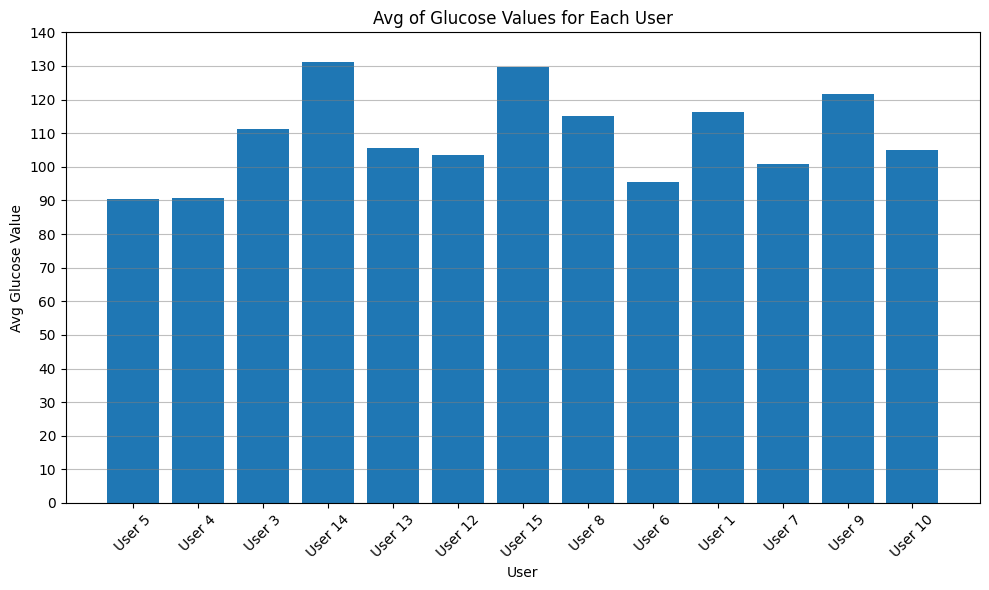

In [52]:

plt.figure(figsize=(10, 6))
plt.bar(users, glucose_avg)
plt.xlabel("User")
plt.ylabel("Avg Glucose Value")
plt.title("Avg of Glucose Values for Each User")
plt.xticks(rotation=45)
plt.ylim(0, 140)
plt.grid(axis='y', color='gray', alpha=0.5)
plt.yticks(range(0, 141, 10))
plt.tight_layout()
plt.show()

In [180]:
# Different Approach
import pandas as pd
import os
import glob

user_dirs = [f for f in os.listdir('Datasets/glucdict-1/Glucdict Dataset/') if 'User' in f]

glucose_column_names = ["index", "timestamp", "glucose", "transmitter", "transmitter_id"]
phone_sensor_column_names = ["phone_sensor_id", "timestamp", "phone_value1", "phone_value2", "phone_value3"]
watch_sensor_column_names = ["watch_sensor_id", "timestamp", "watch_value1", "watch_value2", "watch_value3"]
phone_activity_column_names = ['activity_id', 'activity_name', 'timestamp', 'end_timestamp']

# Load the glucose stats for the user
def load_glucose(user_path):
    path = f"Datasets/glucdict-1/Glucdict Dataset/{user_path}/Glucose/"
    file = os.listdir(path)[0]
    df = pd.read_csv(path+file, names=glucose_column_names, header=1)
    df = df[["timestamp", "glucose"]]
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df = df.set_index("timestamp")
    return df

# Load the phone sensor data for the user
def load_phone_sensor_data(user_path):
    path = f"Datasets/glucdict-1/Glucdict Dataset/{user_path}/Phone/Sensors/"
    try:
        if any("SensorReader.csv" in f for f in os.listdir(path)):
            if user_path == 'User1':
                sensor_file = 'SensorReader.csv'
            else:
                sensor_file = f"{user_path}_SensorReader.csv"
                
            path = f"Datasets/glucdict-1/Glucdict Dataset/{user_path}/Phone/Sensors/{sensor_file}"
            df = pd.read_csv(path, names=phone_sensor_column_names, header=1)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index("timestamp")
            return df
        else:
            csvs = glob.glob(os.path.join(path, "*.csv"))
            frames = []
            for file in csvs:
                df = pd.read_csv(file, names=phone_sensor_column_names, header=1)
                df['timestamp'] = pd.to_datetime(df['timestamp']) 
                df = df.set_index("timestamp")
                frames.append(df)
            return df
    except FileNotFoundError:
        empty = pd.DataFrame(columns=phone_sensor_column_names)
        empty['timestamp'] = pd.to_datetime(empty['timestamp'])
        empty = empty.set_index('timestamp')
        return empty
        
# Load the watch sensor data for the user 
def load_watch_sensor_data(user_path):
    try:
        if user_path == 'User1':
            sensor_file = 'SensorReader.csv'
        else:
            sensor_file = f"{user_path}_SensorReader.csv"
        path = f"Datasets/glucdict-1/Glucdict Dataset/{user_path}/Watch/{sensor_file}"
        df = pd.read_csv(path, names=watch_sensor_column_names, header=1)
        df['timestamp'] = pd.to_datetime(df['timestamp']) 
        df = df.set_index("timestamp")
        return df
    except FileNotFoundError:
        empty = pd.DataFrame(columns=watch_sensor_column_names)
        empty['timestamp'] = pd.to_datetime(empty['timestamp'])
        empty = empty.set_index('timestamp')
        return empty

# Load phone activity for the user
def load_phone_activity_data(user_path):
    try:
        path = f"Datasets/glucdict-1/Glucdict Dataset/{user_path}/Phone/Activities/"
        if any("Activities.csv" in f for f in os.listdir(path)):
            if user_path == 'User1':
                activities_file = 'Activities.csv'
            else:
                activities_file = f"{user_path}_Activities.csv"
                
            path = f"Datasets/glucdict-1/Glucdict Dataset/{user_path}/Phone/Activities/{activities_file}"
            df = pd.read_csv(path, names=phone_activity_column_names, header=1)
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index("timestamp")
            return df
        else:
            csvs = glob.glob(os.path.join(path, "*.csv"))
            frames = []
            for file in csvs:
                df = pd.read_csv(file, names=phone_activity_column_names, header=1)
                df['timestamp'] = pd.to_datetime(df['timestamp']) 
                df = df.set_index("timestamp")
                frames.append(df)
            return df
    except FileNotFoundError:
        empty = pd.DataFrame(columns=phone_activity_column_names)
        empty['timestamp'] = pd.to_datetime(empty['timestamp'])
        empty = empty.set_index('timestamp')
        return empty
        
    
def collect_user(user_path):

    # Load each source
    glucose_df = load_glucose(user_path)
    phone_sensor_df = load_phone_sensor_data(user_path)
    watch_sensor_df = load_watch_sensor_data(user_path)
    phone_activity_df = load_phone_activity_data(user_path)

    # Resample the data for every 5 minutes
    glucose_resampled = glucose_df.resample('5T').agg({
                            'glucose': 'first'
                        })
    
    phone_resampled = phone_sensor_df.resample('5T').agg({
                            'phone_sensor_id': 'first',
                            'phone_value1': 'first',
                            'phone_value2': 'first',
                            'phone_value3': 'first'
                        })

    activity_resampled = phone_activity_df.resample('5T').agg({
                            'activity_id': 'first',
                            'activity_name': 'first',
                            'end_timestamp': 'first'
                        })
    
    watch_resampled = watch_sensor_df.resample('5T').agg({
                            'watch_sensor_id': 'first',
                            'watch_value1': 'first',
                            'watch_value2': 'first',
                            'watch_value3': 'first'
                        })

    # Combine all sources
    combined = glucose_resampled.join([phone_resampled, watch_resampled, activity_resampled])
    combined["user"] = user_path  # tag the user
    return combined.reset_index()



all_users = []

# Loop through each user and collect all the data
for user in user_dirs:
    try:
        df = collect_user(user)
        all_users.append(df)
    except Exception as e:
        print(f"Error processing {user}: {e}")

final_df = pd.concat(all_users, ignore_index=True)


/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:33: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, names=phone_sensor_column_names, header=1)
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:118: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  glucose_resampled = glucose_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:122: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  phone_resampled = phone_sensor_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:129: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  activity_resampled = phone_activity_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb6

Error processing User3: time data "21-10-29 13:42" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.


/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:118: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  glucose_resampled = glucose_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:122: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  phone_resampled = phone_sensor_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:129: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  activity_resampled = phone_activity_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:135: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  watch_resampled = watch_sensor_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb63yfnpyn_td

Error processing User7: Passed header=1 but only 1 lines in file


/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:41: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, names=phone_sensor_column_names, header=1)
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:118: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  glucose_resampled = glucose_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:122: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  phone_resampled = phone_sensor_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb63yfnpyn_tdj80000gn/T/ipykernel_2296/3999586697.py:129: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  activity_resampled = phone_activity_df.resample('5T').agg({
/var/folders/j0/s_ktjdw15zb6

In [182]:
# We don't know which user is actually diabetic
# For the sake of making progress we will assume it is User1
final_df["label"] = final_df["user"].apply(lambda u: 1 if u == "User1" else 0)


X = final_df.drop(columns=["timestamp", "user", "label"])
X['activity_name'] = X['activity_name'].fillna("none")
X = pd.get_dummies(X) 

y = final_df["label"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


F1 Score: 0.0
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      5704
           1       0.00      0.00      0.00       567

    accuracy                           0.91      6271
   macro avg       0.45      0.50      0.48      6271
weighted avg       0.83      0.91      0.87      6271



/Users/shooknasty/Desktop/cap4770/group_project/CAP4770-Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shooknasty/Desktop/cap4770/group_project/CAP4770-Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shooknasty/Desktop/cap4770/group_project/CAP4770-Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [158]:
# Calculate time to train the model
import time

start = time.time()
model.fit(X_train, y_train)
end = time.time()

print(f"Training time: {end - start:.2f} seconds")



Training time: 15.55 seconds


In [156]:
print(y_test.value_counts())


label
0    5704
1     567
Name: count, dtype: int64


/Users/shooknasty/Desktop/cap4770/group_project/CAP4770-Project/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


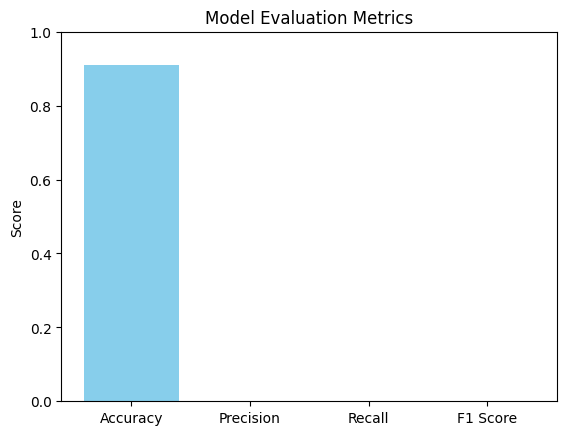

In [172]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title("Model Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

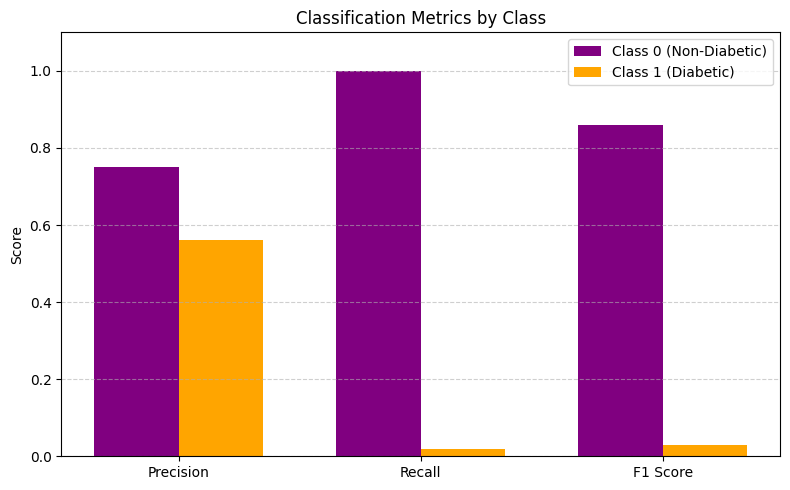

In [192]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from classification report
metrics = ["Precision", "Recall", "F1 Score"]

class_0 = [0.75, 1.00, 0.86]  # Non-diabetic
class_1 = [0.56, 0.02, 0.03]  # Diabetic

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, class_0, width, label='Class 0 (Non-Diabetic)', color='purple')
bars2 = ax.bar(x + width/2, class_1, width, label='Class 1 (Diabetic)', color='orange')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
